# 🥙 LSTM on Recipe Data

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the LSTM](#build)
3. [Train the LSTM](#train)

In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from pprint import pprint
import random
import re
import string

# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, callbacks, losses, utils, metrics, optimizers, preprocessing, datasets

from utils.image import display
from utils.datasets import sample_batches, sample_batch
from utils.losses import root_mean_squared_error

## 0. Parameters <a name="parameters"></a>

In [24]:
MAX_FEATURES = 20000  # Only consider the top 20k words
MAX_LEN = 200  # Only consider the first 200 words of each movie review
EMBEDDING_DIM = 128
N_UNITS = 128
VALIDATION_SPLIT = 0.2
SEED = 42

## 1. Load the data <a name="prepare"></a>

In [21]:
# Load the full dataset
with open('/app/data/epirecipes/full_format_recipes.json') as json_data:
    train_data = json.load(json_data)
    json_data.close()
    

In [126]:
# Filter the dataset
train_data = [x for x in train_data
              if 'calories' in x 
              and x['calories'] is not None
              and x['calories'] > 0
              and x['calories'] < 1000
              and 'ingredients' in x
              and x['ingredients'] is not None
             ]
n_recipes = len(train_data)

random.seed(SEED)
random.shuffle(train_data)

X_data = [' '.join(x['ingredients']) + ' ' + ' '.join(x['directions']) for x in train_data]
y_data = [x['calories'] / 1000.0 for x in train_data]

print(f'{n_recipes} recipes loaded')

14557 recipes loaded


In [127]:
# Split into train and validation sets
n_validation = int(VALIDATION_SPLIT * n_recipes)
n_train = n_recipes - n_validation

X_train = X_data[:n_train]
X_valid = X_data[n_train:]

y_train = y_data[:n_train]
y_valid = y_data[n_train:]

print(f'Train set: {n_train} recipes')
print(f'Validation set: {n_validation} recipes')

Train set: 11646 recipes
Validation set: 2911 recipes


In [128]:
# Display an example of a recipe
pprint(X_data[0])
pprint(y_data[0])

('1 cup finely grated peeled fresh horseradish root (about 4 ounces) 1 8-ounce '
 'container crème fraîche or sour cream 1/4 cup white wine vinegar Coarse '
 'kosher salt 1 1/2 pounds red onions, very thinly sliced 2 cups dry red wine '
 '2 tablespoons honey 1 tablespoon chopped fresh thyme 2 tablespoons red wine '
 'vinegar 10 7- to 8-inch-diameter flour tortillas, each cut into 5-inch '
 'square 2 tablespoons olive oil 4 9- to 10-ounce boneless rib-eye steaks, '
 'excess fat trimmed Fresh cilantro sprigs Mix first 3 ingredients in small '
 'bowl to blend. Season to taste with kosher salt. (Can be prepared 1 day '
 'ahead. Cover and refrigerate.) Combine onions, wine, honey, and thyme in '
 'large skillet. Bring to boil. Reduce heat to medium-low and simmer uncovered '
 'until wine is almost absorbed, stirring occasionally, about 55 minutes. Mix '
 'in red wine vinegar. Simmer 10 minutes to blend flavors, adding water by '
 'tablespoonfuls to moisten if jam is dry and stirring often (

## Prepare the data

In [129]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

In [130]:
# Vectorise the text into ints
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=MAX_FEATURES,
    output_mode="int",
    output_sequence_length=MAX_LEN,
)

# Adapt the mapping to the training set
vectorize_layer.adapt(X_train)

In [131]:
# Convert the text to ints
X_train_int = vectorize_layer(X_train)
X_valid_int = vectorize_layer(X_valid)

In [132]:
# Pad sequences
X_train_int = preprocessing.sequence.pad_sequences(X_train_int, maxlen=MAX_LEN)
X_valid_int = preprocessing.sequence.pad_sequences(X_valid_int, maxlen=MAX_LEN)

In [133]:
# Convert y values to numpy arrays
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [134]:
pprint(X_train_int[0])

array([   4,   11,   93,  135,  127,   33,  847,  865,   14,   36,  100,
          4,  687,  502,  737,  879,   24,  364,   50,   27,   11,  130,
        168,  112,  284,  251,   17,    4,   12,  195,  120,  148,  224,
        183,  104,    9,   31,  119,  120,  168,    9,   16,  361,    4,
         40,   29,   33,  219,    9,   16,  120,  168,  112,   88,  318,
          3, 2213,   68,  688,   71,   39,   20, 1703,  813,    9,   16,
         73,   26,   36,  484,    3,  932,  618, 2641,  594,  476,  362,
        337,   33,  240,  316,  132,  397,   25,  158,    5,   57,   28,
          3,  145,   80,    3,  109,    8,  251,   17,   84,   70,  196,
          4,  213,   81,   61,    2,  239,  121,  148,  168,  361,    2,
        219,    5,   21,   65,   95,    3,   78,  201,   19,    3,  448,
          2,   76,  297,   10,  168,   41,  526,  654,   53,  106,   14,
       1601,   13,  132,    5,  120,  168,  112,   76,   88,   13,    3,
        145,  938,  457,   34,  214, 1170,    3, 14

In [135]:
pprint(y_train[0])

0.232


## 2. Build the LSTM <a name="build"></a>

In [136]:
inputs = layers.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(MAX_FEATURES, EMBEDDING_DIM)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(N_UNITS, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(N_UNITS))(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = models.Model(inputs, outputs)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9 (Embedding)     (None, None, 128)         2560000   
                                                                 
 bidirectional_16 (Bidirecti  (None, None, 128)        98816     
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,757,761
Trainable params: 2,757,761
Non-tra

In [137]:
model.compile("adam", "mse", metrics = ["mae"])

In [ ]:
model.fit(X_train_int, y_train, batch_size=32, epochs=2, validation_data=(X_valid_int, y_valid))

Epoch 1/2
352/364 [============================>.] - ETA: 2s - loss: 0.0216 - mae: 0.1110

In [141]:
preds = model.predict(X_valid_int)

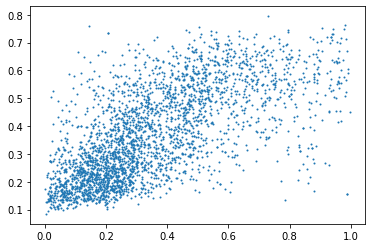

In [142]:
plt.scatter(y_valid, preds, s = 1)

In [140]:
class LSTM(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(LSTM, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.loss_fn = BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = Mean(name="d_loss")
        self.d_real_acc_metric = BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = BinaryAccuracy(name="d_acc")
        self.g_loss_metric = Mean(name="g_loss")
        self.g_acc_metric = BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.d_real_acc_metric, self.d_fake_acc_metric, self.d_acc_metric, self.g_loss_metric, self.g_acc_metric]
    
    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            generated_images = self.generator(random_latent_vectors, training = True)
            real_predictions = self.discriminator(real_images, training = True)
            fake_predictions = self.discriminator(generated_images, training = True)
            
            real_labels = tf.ones_like(real_predictions) 
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(tf.shape(real_predictions))
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(tf.shape(fake_predictions))
            
            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0
            
            g_loss = self.loss_fn(real_labels, fake_predictions)
            
        
        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)

        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state([real_labels, fake_labels], [real_predictions, fake_predictions])
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)
        
        return {m.name: m.result() for m in self.metrics}


NameError: name 'Model' is not defined

In [ ]:
#Create a GAN
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM)

In [ ]:
if LOAD_MODEL:
    gan.load_weights('./checkpoint/checkpoint.ckpt')

## 3. Train the GAN <a name="train"></a>

In [ ]:
gan.compile(
    d_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2),
    g_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2),
)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = TensorBoard(log_dir="./logs")

class ImageGenerator(Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch))
        


In [ ]:
gan.fit(
    train, 
    epochs=EPOCHS, 
    # steps_per_epoch = 100, 
    # initial_epoch = 164,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)

In [ ]:
# Save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")